In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
# from Helmholtz2D_model_tf import Sampler, Helmholtz2D
import timeit
import os
os.environ["KMP_WARNINGS"] = "FALSE" 
import time
import scipy
import scipy.io
import pickle


In [2]:


class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name=None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name

    def sample(self, N):
        x = self.coords[0:1, :] + (self.coords[1:2, :] - self.coords[0:1, :]) * np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

class Helmholtz2D:
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, model, stiff_ratio):
        # Normalization constants
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_x1, self.sigma_x1 = self.mu_X[0], self.sigma_X[0]
        self.mu_x2, self.sigma_x2 = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # Helmoholtz constant
        self.lam = tf.constant(lam, dtype=tf.float32)

        # Mode
        self.model = model

        # Record stiff ratio
        self.stiff_ratio = stiff_ratio

        # Adaptive constant
        self.beta = 0.9
        self.adaptive_constant_u1_val = np.array(2.0)
        self.adaptive_constant_u2_val = np.array(2.0)
        self.adaptive_constant_u3_val = np.array(2.0)
        self.adaptive_constant_u4_val = np.array(2.0)
        self.adaptive_constant_f_val  = np.array(2.0)

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        if model in ['M3', 'M4']:
            # Initialize encoder weights and biases
            self.encoder_weights_1 = self.xavier_init([2, layers[1]])
            self.encoder_biases_1 = self.xavier_init([1, layers[1]])

            self.encoder_weights_2 = self.xavier_init([2, layers[1]])
            self.encoder_biases_2 = self.xavier_init([1, layers[1]])

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))

        # Define placeholders and computational graph
        self.x1_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc3_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_bc4_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.x1_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x2_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.r_tf = tf.placeholder(tf.float32, shape=(None, 1))

        # Define placeholder for adaptive constant
        self.adaptive_constant_u1_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_u1_val.shape)
        self.adaptive_constant_u2_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_u2_val.shape)
        self.adaptive_constant_u3_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_u3_val.shape)
        self.adaptive_constant_u4_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_u4_val.shape)
        self.adaptive_constant_f_tf = tf.placeholder(tf.float32, shape=self.adaptive_constant_f_val.shape)

        # Evaluate predictions
        self.u_bc1_pred = self.net_u(self.x1_bc1_tf, self.x2_bc1_tf)
        self.u_bc2_pred = self.net_u(self.x1_bc2_tf, self.x2_bc2_tf)
        self.u_bc3_pred = self.net_u(self.x1_bc3_tf, self.x2_bc3_tf)
        self.u_bc4_pred = self.net_u(self.x1_bc4_tf, self.x2_bc4_tf)

        self.u_pred = self.net_u(self.x1_u_tf, self.x2_u_tf)
        self.r_pred = self.net_r(self.x1_r_tf, self.x2_r_tf)

        # Boundary loss
        self.loss_bcs1 = tf.reduce_mean(tf.square(self.u_bc1_tf - self.u_bc1_pred))
        self.loss_bcs2 = tf.reduce_mean(tf.square(self.u_bc2_tf - self.u_bc2_pred))
        self.loss_bcs3 = tf.reduce_mean(tf.square(self.u_bc3_tf - self.u_bc3_pred))
        self.loss_bcs4 = tf.reduce_mean(tf.square(self.u_bc4_tf - self.u_bc4_pred))
        self.loss_bcs = (self.loss_bcs1 + self.loss_bcs2 + self.loss_bcs3 + self.loss_bcs4)

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_tf - self.r_pred))

        self.loss =  self.loss_res +  self.adaptive_constant_u1_tf * self.loss_bcs1 +  self.adaptive_constant_u2_tf * self.loss_bcs2+ \
              self.adaptive_constant_u3_tf * self.loss_bcs3 +  self.adaptive_constant_u4_tf * self.loss_bcs4
        
        # self.loss =  self.loss_res +  self.adaptive_constant_u1_tf *  self.loss_bcs 


        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)


        self.loss_tensor_list = [self.loss ,  self.loss_res,  self.loss_bcs1 ,  self.loss_bcs2 ,  self.loss_bcs3  ,  self.loss_bcs4] 
        self.loss_list = ["total loss" , "loss_res" , "loss_bcs1" , "loss_bcs2", "loss_bcs3" ,  "loss_bcs4"] 

        self.epoch_loss = dict.fromkeys(self.loss_list, 0)
        self.loss_history = dict((loss, []) for loss in self.loss_list)
        
    
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

 ############################################################

    def assign_batch_losses(self, batch_losses):
        for loss_values, key in zip(batch_losses, self.epoch_loss):
            self.epoch_loss[key] = loss_values

    def plot_loss_history(self ):

        fig, ax = plt.subplots()
        fig.set_size_inches([15,8])
        for key in self.loss_history:
            print("Final loss %s: %e" % (key, self.loss_history[key][-1]))
            ax.semilogy(self.loss_history[key], label=key)
        ax.set_xlabel("epochs", fontsize=15)
        ax.set_ylabel("loss", fontsize=15)
        ax.tick_params(labelsize=15)
        ax.legend()
        plt.show()
    ############################################################
  
     # Create dictionary to store gradients
    def generate_grad_dict(self, layers):
        num = len(layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict

    # Save gradients
    def save_gradients(self, tf_dict):
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_res_value, grad_bcs_value = self.sess.run([self.grad_res[i], self.grad_bcs[i]], feed_dict=tf_dict)

            # save gradients of loss_res and loss_bcs
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res_value.flatten())
            self.dict_gradients_bcs_layers['layer_' + str(i + 1)].append(grad_bcs_value.flatten())
        return None

    # Compute the Hessian
    def flatten(self, vectors):
        return tf.concat([tf.reshape(v, [-1]) for v in vectors], axis=0)

    def get_Hv(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss, self.weights))
        vprod = tf.math.multiply(loss_gradients,tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_Hv_res(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_res, self.weights))
        vprod = tf.math.multiply(loss_gradients, tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_Hv_bcs(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_bcs, self.weights))
        vprod = tf.math.multiply(loss_gradients,
                                 tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weights))
        return Hv_op

    def get_H_op(self):
        self.P = self.flatten(self.weights).get_shape().as_list()[0]
        H = tf.map_fn(self.get_Hv, tf.eye(self.P, self.P),dtype='float32')
        H_bcs = tf.map_fn(self.get_Hv_bcs, tf.eye(self.P, self.P), dtype='float32')
        H_res = tf.map_fn(self.get_Hv_res, tf.eye(self.P, self.P), dtype='float32')

        return H, H_bcs, H_res

    # Xavier initialization
    def xavier_init(self,size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H):
        if self.model in ['M1', 'M2']:
            num_layers = len(self.layers)
            for l in range(0, num_layers - 2):
                W = self.weights[l]
                b = self.biases[l]
                H = tf.tanh(tf.add(tf.matmul(H, W), b))
            W = self.weights[-1]
            b = self.biases[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

        if self.model in ['M3', 'M4']:
            num_layers = len(self.layers)
            encoder_1 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_1), self.encoder_biases_1))
            encoder_2 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weights_2), self.encoder_biases_2))

            for l in range(0, num_layers - 2):
                W = self.weights[l]
                b = self.biases[l]
                H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_1) + \
                    tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_2)

            W = self.weights[-1]
            b = self.biases[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

    # Forward pass for u
    def net_u(self, x1, x2):
        u = self.forward_pass(tf.concat([x1, x2], 1))
        return u

    # Forward pass for residual
    def net_r(self, x1, x2):
        u = self.net_u(x1, x2)
        residual = self.operator(u, x1, x2,
                                 self.lam,
                                 self.sigma_x1,
                                 self.sigma_x2)
        return residual

    # Feed minibatch
    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    # Trains the model by minimizing the MSE loss
    def train(self, nIter=10000, batch_size=128):

        start_time = timeit.default_timer()
        # Fetch boundary mini-batches
        batch_size = 350
        X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
        X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
        X_bc3_batch, u_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
        X_bc4_batch, u_bc4_batch = self.fetch_minibatch(self.bcs_sampler[3], batch_size)

        # Fetch residual mini-batch
        batch_size = 1000

        X_res_batch, f_res_batch = self.fetch_minibatch(self.res_sampler, batch_size)

        # Define a dictionary for associating placeholders with data
        tf_dict = {self.x1_bc1_tf: X_bc1_batch[:, 0:1], self.x2_bc1_tf: X_bc1_batch[:, 1:2],
                    self.u_bc1_tf: u_bc1_batch,
                    self.x1_bc2_tf: X_bc2_batch[:, 0:1], self.x2_bc2_tf: X_bc2_batch[:, 1:2],
                    self.u_bc2_tf: u_bc2_batch,
                    self.x1_bc3_tf: X_bc3_batch[:, 0:1], self.x2_bc3_tf: X_bc3_batch[:, 1:2],
                    self.u_bc3_tf: u_bc3_batch,
                    self.x1_bc4_tf: X_bc4_batch[:, 0:1], self.x2_bc4_tf: X_bc4_batch[:, 1:2],
                    self.u_bc4_tf: u_bc4_batch,
                    self.x1_r_tf: X_res_batch[:, 0:1], self.x2_r_tf: X_res_batch[:, 1:2], 
                    self.r_tf: f_res_batch,
                    self.adaptive_constant_u1_tf:  self.adaptive_constant_u1_val,
                    self.adaptive_constant_u2_tf:  self.adaptive_constant_u2_val,
                    self.adaptive_constant_u3_tf:  self.adaptive_constant_u3_val,
                    self.adaptive_constant_u4_tf:  self.adaptive_constant_u4_val,
                    self.adaptive_constant_f_tf:  self.adaptive_constant_f_val
                    }

        for it in range(1 , nIter):

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)
            _, batch_losses = self.sess.run([self.train_op, self.loss_tensor_list] ,tf_dict)

            # Print
            if it % 100 == 0:

                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value, loss_res , loss_bcs1 , loss_bcs2 , loss_bcs3 , loss_bcs4 = self.sess.run([self.loss_bcs, self.loss_res, self.loss_bcs1, self.loss_bcs2, self.loss_bcs3, self.loss_bcs4], tf_dict)

                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_res: %.3e, loss_bcs1: %.3e , loss_bcs2: %.3e, loss_bcs3: %.3e, loss_bcs4: %.3e,Time: %.2f' % (it, loss_value, loss_bcs_value, loss_res,
                                                                                                                                                              loss_bcs1 , loss_bcs2 , loss_bcs3 , loss_bcs4 , elapsed))

               
                if it % 1000 == 0:

                    self.adaptive_constant_u1_val = 1000 * loss_bcs_value  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    self.adaptive_constant_u2_val = 1000 * loss_bcs2  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    self.adaptive_constant_u3_val = 1000 * loss_bcs3  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    self.adaptive_constant_u4_val = 1000 * loss_bcs4  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    self.adaptive_constant_f_val = 10 * loss_res  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    # self.adaptive_constant_f_val = 10 * loss_res  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                # self.adpative_constant_log.append(self.adaptive_constant_u_val)

                    print("adaptive_constant_u1_val: {:.3f}".format(self.adaptive_constant_u1_val))
                    print("adaptive_constant_u2_val: {:.3f}".format(self.adaptive_constant_u2_val))
                    print("adaptive_constant_u3_val: {:.3f}".format(self.adaptive_constant_u3_val))
                    print("adaptive_constant_u4_val: {:.3f}".format(self.adaptive_constant_u4_val))
                    print("adaptive_constant_f_val: {:.3f}".format(self.adaptive_constant_f_val))

                start_time = timeit.default_timer()
            self.assign_batch_losses(batch_losses)
            for key in self.loss_history:
                self.loss_history[key].append(self.epoch_loss[key])
                
  
   # Trains the model by minimizing the MSE loss
    def trainmb(self, nIter=10000, batch_size=128):

        start_time = timeit.default_timer()
        # Fetch boundary mini-batches
        for it in range(1 , nIter):
            X_bc1_batch, u_bc1_batch = self.fetch_minibatch(self.bcs_sampler[0], batch_size)
            X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)
            X_bc3_batch, u_bc3_batch = self.fetch_minibatch(self.bcs_sampler[2], batch_size)
            X_bc4_batch, u_bc4_batch = self.fetch_minibatch(self.bcs_sampler[3], batch_size)

            # Fetch residual mini-batch

            X_res_batch, f_res_batch = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.x1_bc1_tf: X_bc1_batch[:, 0:1], self.x2_bc1_tf: X_bc1_batch[:, 1:2],
                        self.u_bc1_tf: u_bc1_batch,
                        self.x1_bc2_tf: X_bc2_batch[:, 0:1], self.x2_bc2_tf: X_bc2_batch[:, 1:2],
                        self.u_bc2_tf: u_bc2_batch,
                        self.x1_bc3_tf: X_bc3_batch[:, 0:1], self.x2_bc3_tf: X_bc3_batch[:, 1:2],
                        self.u_bc3_tf: u_bc3_batch,
                        self.x1_bc4_tf: X_bc4_batch[:, 0:1], self.x2_bc4_tf: X_bc4_batch[:, 1:2],
                        self.u_bc4_tf: u_bc4_batch,
                        self.x1_r_tf: X_res_batch[:, 0:1], self.x2_r_tf: X_res_batch[:, 1:2], 
                        self.r_tf: f_res_batch,
                        self.adaptive_constant_u1_tf:  self.adaptive_constant_u1_val,
                        self.adaptive_constant_u2_tf:  self.adaptive_constant_u2_val,
                        self.adaptive_constant_u3_tf:  self.adaptive_constant_u3_val,
                        self.adaptive_constant_u4_tf:  self.adaptive_constant_u4_val,
                        self.adaptive_constant_f_tf:  self.adaptive_constant_f_val
                        }


            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)
            _, batch_losses = self.sess.run([self.train_op, self.loss_tensor_list] ,tf_dict)

            # Print
            if it % 100 == 0:

                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value, loss_res , loss_bcs1 , loss_bcs2 , loss_bcs3 , loss_bcs4 = self.sess.run([self.loss_bcs, self.loss_res, self.loss_bcs1, self.loss_bcs2, self.loss_bcs3, self.loss_bcs4], tf_dict)

                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_res: %.3e, loss_bcs1: %.3e , loss_bcs2: %.3e, loss_bcs3: %.3e, loss_bcs4: %.3e,Time: %.2f' % (it, loss_value, loss_bcs_value, loss_res,
                                                                                                                                                              loss_bcs1 , loss_bcs2 , loss_bcs3 , loss_bcs4 , elapsed))

               
                if it % 1000 == 0:

                    self.adaptive_constant_u1_val = 1000 * loss_bcs_value  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    self.adaptive_constant_u2_val = 1000 * loss_bcs2  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    self.adaptive_constant_u3_val = 1000 * loss_bcs3  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    self.adaptive_constant_u4_val = 1000 * loss_bcs4  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    self.adaptive_constant_f_val = 10 * loss_res  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                    # self.adaptive_constant_f_val = 10 * loss_res  #adaptive_constant_value * (1.0 - self.beta)  + self.beta * self.adaptive_constant_val
                # self.adpative_constant_log.append(self.adaptive_constant_u_val)

                    print("adaptive_constant_u1_val: {:.3f}".format(self.adaptive_constant_u1_val))
                    print("adaptive_constant_u2_val: {:.3f}".format(self.adaptive_constant_u2_val))
                    print("adaptive_constant_u3_val: {:.3f}".format(self.adaptive_constant_u3_val))
                    print("adaptive_constant_u4_val: {:.3f}".format(self.adaptive_constant_u4_val))
                    print("adaptive_constant_f_val: {:.3f}".format(self.adaptive_constant_f_val))

                start_time = timeit.default_timer()
            self.assign_batch_losses(batch_losses)
            for key in self.loss_history:
                self.loss_history[key].append(self.epoch_loss[key])

    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x1_u_tf: X_star[:, 0:1], self.x2_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.x1_r_tf: X_star[:, 0:1], self.x2_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star



In [3]:
a_1 = 1
a_2 = 4

def u(x, a_1, a_2):
    return np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])

def u_xx(x, a_1, a_2):
    return - (a_1 * np.pi) ** 2 * np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])

def u_yy(x, a_1, a_2):
    return - (a_2 * np.pi) ** 2 * np.sin(a_1 * np.pi * x[:, 0:1]) * np.sin(a_2 * np.pi * x[:, 1:2])

# Forcing
def f(x, a_1, a_2, lam):
    return u_xx(x, a_1, a_2) + u_yy(x, a_1, a_2) + lam * u(x, a_1, a_2)

def operator(u, x1, x2, lam, sigma_x1=1.0, sigma_x2=1.0):
    u_x1 = tf.gradients(u, x1)[0] / sigma_x1
    u_x2 = tf.gradients(u, x2)[0] / sigma_x2
    u_xx1 = tf.gradients(u_x1, x1)[0] / sigma_x1
    u_xx2 = tf.gradients(u_x2, x2)[0] / sigma_x2
    residual = u_xx1 + u_xx2 + lam * u
    return residual

# Parameter
lam = 1.0

###########################################################
def test_method(method , layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, mode, stiff_ratio , X_star , u_star , f_star):

    model = Helmholtz2D(layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, mode, stiff_ratio)

    # Train model
    start_time = time.time()

    if method =="full_batch":
        model.train(nIter=40001)
    elif method =="mini_batch":
        model.trainmb(nIter=40001, batch_size=128)
    else:
        print("unknown method!")
    elapsed = time.time() - start_time


    # Predictions
    u_pred = model.predict_u(X_star)
    f_pred = model.predict_r(X_star)

    # Relative error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

    print('Relative L2 error_u: {:.2e}'.format(error_u))
    print('Relative L2 error_u: {:.2e}'.format(error_f))

    return [elapsed, error_u , error_f]



In [4]:

# Parameter
lam = 1.0
# Define model
mode = 'M2'            # Method: 'M1', 'M2', 'M3', 'M4'
stiff_ratio = False    # Log the eigenvalues of Hessian of losses

layers = [2, 50, 50, 50, 1]
# Domain boundaries
bc1_coords = np.array([[-1.0, -1.0], [1.0, -1.0]])
bc2_coords = np.array([[1.0, -1.0],[1.0, 1.0]])
bc3_coords = np.array([[1.0, 1.0], [-1.0, 1.0]])
bc4_coords = np.array([[-1.0, 1.0], [-1.0, -1.0]])

dom_coords = np.array([[-1.0, -1.0], [1.0, 1.0]])


# Test data
nn = 100
x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
x1, x2 = np.meshgrid(x1, x2)
X_star = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))

# Exact solution
u_star = u(X_star, a_1, a_2)
f_star = f(X_star, a_1, a_2, lam)

iterations = 2
methods = ["mini_batch" , "full_batch"]

result_dict =  dict((mtd, []) for mtd in methods)

for mtd in methods:
    print("Method: ", mtd)
    time_list = []
    error_u_list = []
    error_f_list = []
    
    for index in range(iterations):
    # Create initial conditions samplers
        ics_sampler = None
        print("Epoch: ", str(index+1))
        # Create boundary conditions samplers
        bc1 = Sampler(2, bc1_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC1')
        bc2 = Sampler(2, bc2_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC2')
        bc3 = Sampler(2, bc3_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC3')
        bc4 = Sampler(2, bc4_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC4')
        bcs_sampler = [bc1, bc2, bc3, bc4]

        # Create residual sampler
        res_sampler = Sampler(2, dom_coords, lambda x: f(x, a_1, a_2, lam), name='Forcing')

        [elapsed, error_u , error_f] = test_method(mtd , layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, mode, stiff_ratio , X_star , u_star , f_star)


        print('Relative L2 error_u: {:.2e}'.format(error_u))
        print('Relative L2 error_u: {:.2e}'.format(error_f))

        time_list.append(elapsed)
        error_u_list.append(error_u)
        error_f_list.append(error_f)

    print("\n\nMethod: ", mtd)
    print("\naverage of time_list:" , sum(time_list) / len(time_list) )
    print("average of error_u_list:" , sum(error_u_list) / len(error_u_list) )
    print("average of error_f_list:" , sum(error_f_list) / len(error_f_list) )

    result_dict[mtd] = [time_list ,error_u_list ,  error_f_list]
    # scipy.io.savemat("M2_result_"+str(iterations)+"_"+mtd+".mat" , {'time_list':np.array(time_list),'error_u_list':np.array(error_u_list),'error_f_list':np.array(error_f_list)})

scipy.io.savemat("Helmholtz2D_M4_result_"+str(iterations)+".mat" , result_dict)




Method:  mini_batch
Epoch:  1



2023-11-21 23:47:55.284148: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 23:47:55.310014: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-11-21 23:47:55.310769: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x564556f634d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-21 23:47:55.310785: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-21 23:47:55.311366: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.





It: 100, Loss: 7.029e+03, Loss_bcs: 1.083e+00, Loss_res: 7.027e+03, loss_bcs1: 2.447e-01 , loss_bcs2: 4.134e-01, loss_bcs3: 3.795e-01, loss_bcs4: 4.574e-02,Time: 4.28
It: 200, Loss: 6.617e+03, Loss_bcs: 4.948e+00, Loss_res: 6.607e+03, loss_bcs1: 9.178e-01 , loss_bcs2: 7.605e-01, loss_bcs3: 2.656e+00, loss_bcs4: 6.134e-01,Time: 1.35
It: 300, Loss: 5.472e+03, Loss_bcs: 1.557e+01, Loss_res: 5.441e+03, loss_bcs1: 6.393e+00 , loss_bcs2: 1.960e+00, loss_bcs3: 6.543e+00, loss_bcs4: 6.698e-01,Time: 1.36
It: 400, Loss: 2.445e+03, Loss_bcs: 1.221e+01, Loss_res: 2.420e+03, loss_bcs1: 5.965e+00 , loss_bcs2: 1.656e+00, loss_bcs3: 3.918e+00, loss_bcs4: 6.671e-01,Time: 1.35
It: 500, Loss: 7.255e+02, Loss_bcs: 2.199e+01, Loss_res: 6.815e+02, loss_bcs1: 8.914e+00 , loss_bcs2: 2.789e+00, loss_bcs3: 9.530e+00, loss_bcs4: 7.609e-01,Time: 1.16
It: 600, Loss: 1.493e+02, Loss_bcs: 1.702e+01, Loss_res: 1.153e+02, loss_bcs1: 5.698e+00 , loss_bcs2: 3.847e+00, loss_bcs3: 7.089e+00, loss_bcs4: 3.885e-01,Time: 

In [3]:

# Domain boundaries
bc1_coords = np.array([[-1.0, -1.0], [1.0, -1.0]])
bc2_coords = np.array([[1.0, -1.0], [1.0, 1.0]])
bc3_coords = np.array([[1.0, 1.0],  [-1.0, 1.0]])
bc4_coords = np.array([[-1.0, 1.0],  [-1.0, -1.0]])

dom_coords = np.array([[-1.0, -1.0],  [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = None

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC2')
bc3 = Sampler(2, bc3_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC3')
bc4 = Sampler(2, bc4_coords, lambda x: u(x, a_1, a_2), name='Dirichlet BC4')
bcs_sampler = [bc1, bc2, bc3, bc4]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: f(x, a_1, a_2, lam), name='Forcing')

# Define model
mode = 'M2'            # Method: 'M1', 'M2', 'M3', 'M4'
stiff_ratio = False    # Log the eigenvalues of Hessian of losses

layers = [2, 50, 50, 50, 1]
model = Helmholtz2D(layers, operator, ics_sampler, bcs_sampler, res_sampler, lam, mode, stiff_ratio)


2023-11-21 13:30:49.197384: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 13:30:49.226041: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2023-11-21 13:30:49.226559: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563fcd2d3400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-21 13:30:49.226572: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-21 13:30:49.230183: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:

# Train model
model.train(nIter=40001, batch_size=128)


It: 100, Loss: 3.255e+03, Loss_bcs: 5.409e+00, Loss_res: 3.244e+03, loss_bcs1: 1.320e+00 , loss_bcs2: 1.249e+00, loss_bcs3: 1.338e+00, loss_bcs4: 1.502e+00,Time: 4.86
It: 200, Loss: 1.212e+02, Loss_bcs: 6.881e+00, Loss_res: 1.074e+02, loss_bcs1: 1.054e+00 , loss_bcs2: 3.865e-01, loss_bcs3: 5.895e-01, loss_bcs4: 4.850e+00,Time: 1.84
It: 300, Loss: 1.988e+01, Loss_bcs: 2.404e+00, Loss_res: 1.507e+01, loss_bcs1: 6.584e-01 , loss_bcs2: 2.838e-01, loss_bcs3: 9.541e-01, loss_bcs4: 5.074e-01,Time: 1.86
It: 400, Loss: 9.266e+00, Loss_bcs: 1.584e+00, Loss_res: 6.098e+00, loss_bcs1: 5.188e-01 , loss_bcs2: 1.597e-01, loss_bcs3: 7.237e-01, loss_bcs4: 1.815e-01,Time: 1.90
It: 500, Loss: 5.600e+00, Loss_bcs: 1.115e+00, Loss_res: 3.370e+00, loss_bcs1: 3.335e-01 , loss_bcs2: 9.954e-02, loss_bcs3: 5.794e-01, loss_bcs4: 1.027e-01,Time: 1.87
It: 600, Loss: 3.955e+00, Loss_bcs: 8.692e-01, Loss_res: 2.216e+00, loss_bcs1: 2.552e-01 , loss_bcs2: 5.233e-02, loss_bcs3: 4.937e-01, loss_bcs4: 6.807e-02,Time: 1.9

Relative L2 error_u: 1.86e-02
Relative L2 error_u: 7.93e-03


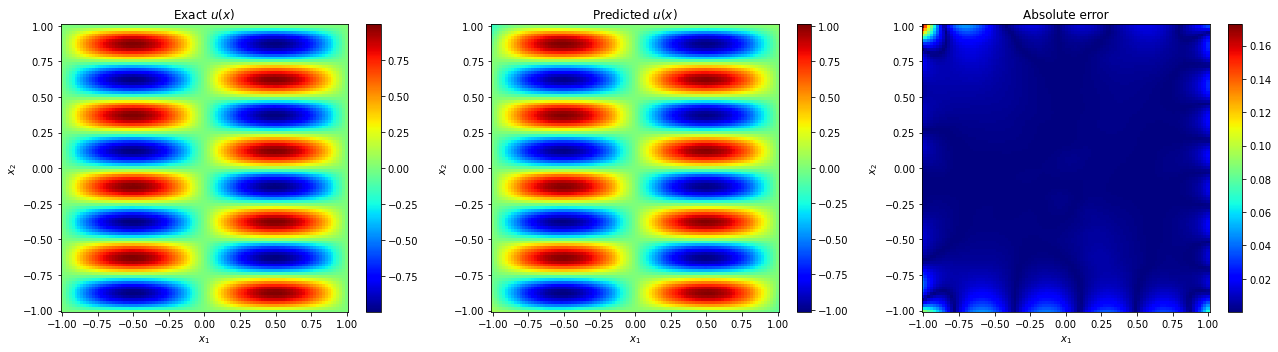

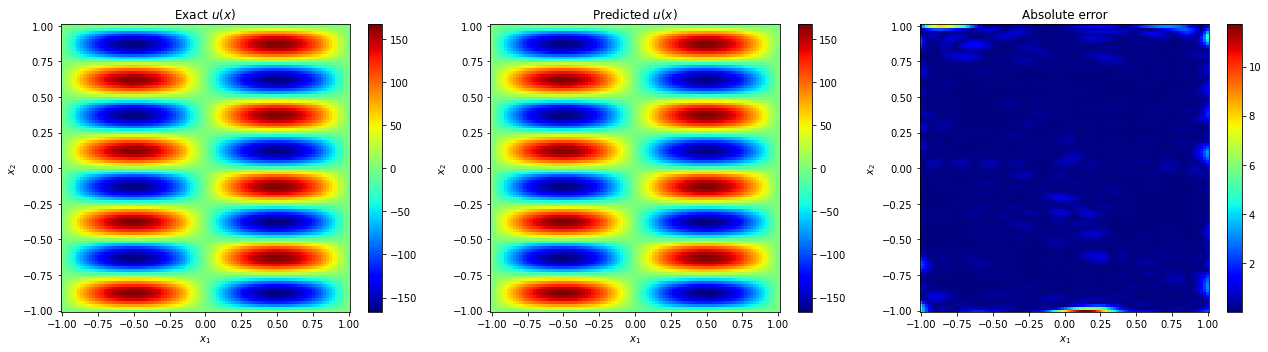

In [5]:

# Test data
nn = 100
x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
x1, x2 = np.meshgrid(x1, x2)
X_star = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))

# Exact solution
u_star = u(X_star, a_1, a_2)
f_star = f(X_star, a_1, a_2, lam)

# Predictions
u_pred = model.predict_u(X_star)
f_pred = model.predict_r(X_star)

# Relative error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_u: {:.2e}'.format(error_f))

### Plot ###

# Exact solution & Predicted solution
# Exact soluton
U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

# Predicted solution
U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(x1, x2, U_star, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Exact $u(x)$')

plt.subplot(1, 3, 2)
plt.pcolor(x1, x2, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Predicted $u(x)$')

plt.subplot(1, 3, 3)
plt.pcolor(x1, x2, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(x1, x2, F_star, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Exact $u(x)$')

plt.subplot(1, 3, 2)
plt.pcolor(x1, x2, F_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Predicted $u(x)$')

plt.subplot(1, 3, 3)
plt.pcolor(x1, x2, np.abs(F_star - F_pred), cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

Final loss total loss: 1.228667e-02
Final loss loss_res: 7.148970e-03
Final loss loss_bcs1: 1.053590e-03
Final loss loss_bcs2: 2.543512e-04
Final loss loss_bcs3: 6.080988e-04
Final loss loss_bcs4: 6.528093e-04


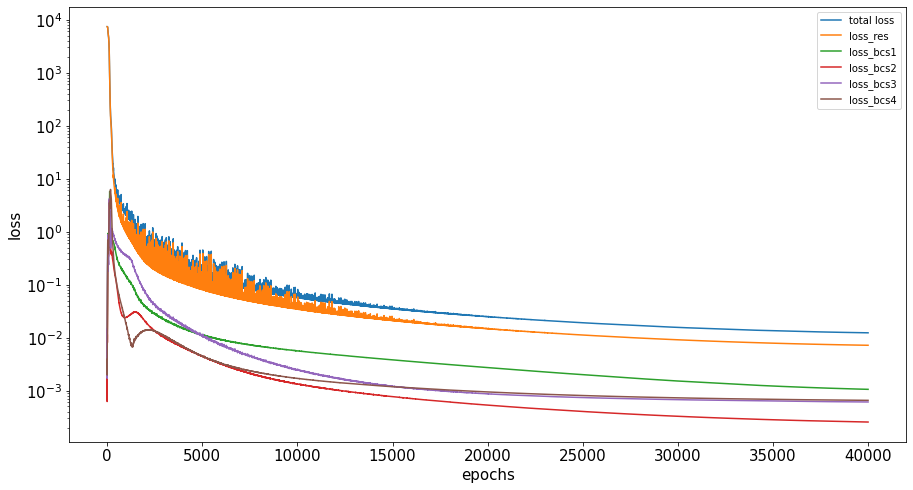

In [6]:
model.plot_loss_history()



Final loss total loss: 1.420423e+00
Final loss loss_res: 9.498014e-01
Final loss loss_bcs1: 7.854943e-02
Final loss loss_bcs2: 2.595772e-02
Final loss loss_bcs3: 9.461753e-02
Final loss loss_bcs4: 2.680402e-02


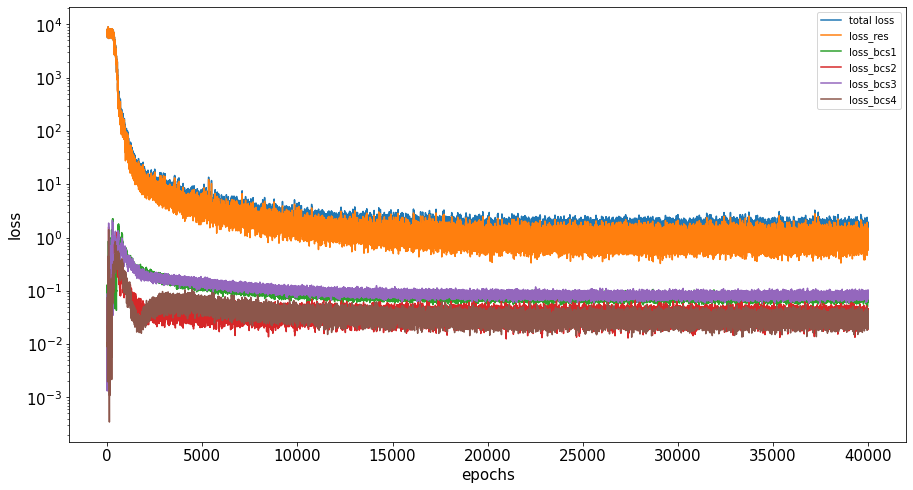

In [8]:
def plot_loss_history(self ):

    fig, ax = plt.subplots()
    fig.set_size_inches([15,8])
    for key in self.loss_history:
        print("Final loss %s: %e" % (key, self.loss_history[key][-1]))
        ax.semilogy(self.loss_history[key], label=key)
    ax.set_xlabel("epochs", fontsize=15)
    ax.set_ylabel("loss", fontsize=15)
    ax.tick_params(labelsize=15)
    ax.legend()
    plt.show()

plot_loss_history(model)

Relative L2 error_u: 1.89e-01
Relative L2 error_u: 1.74e-02


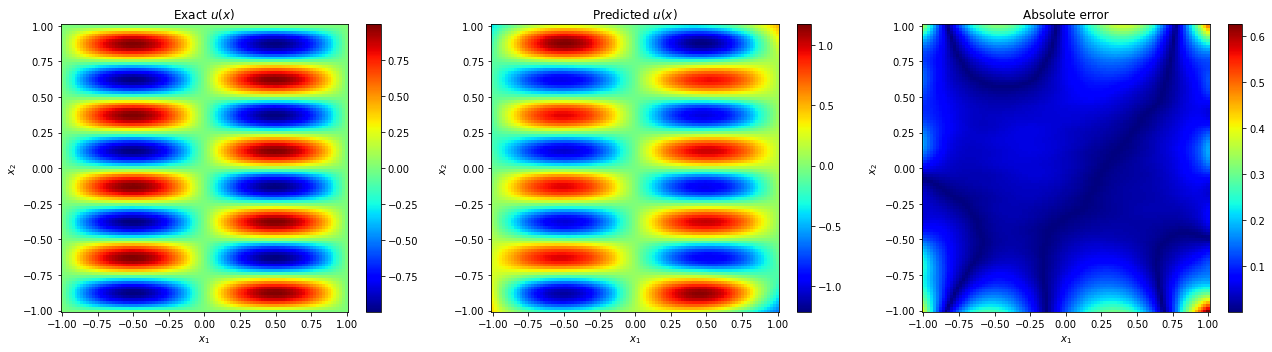

In [5]:

# Test data
nn = 100
x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
x1, x2 = np.meshgrid(x1, x2)
X_star = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))

# Exact solution
u_star = u(X_star, a_1, a_2)
f_star = f(X_star, a_1, a_2, lam)

# Predictions
u_pred = model.predict_u(X_star)
f_pred = model.predict_r(X_star)

# Relative error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_u: {:.2e}'.format(error_f))

### Plot ###

# Exact solution & Predicted solution
# Exact soluton
U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

# Predicted solution
U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(x1, x2, U_star, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Exact $u(x)$')

plt.subplot(1, 3, 2)
plt.pcolor(x1, x2, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Predicted $u(x)$')

plt.subplot(1, 3, 3)
plt.pcolor(x1, x2, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()


Relative L2 error_u: 4.96e-01
Relative L2 error_u: 1.66e-02


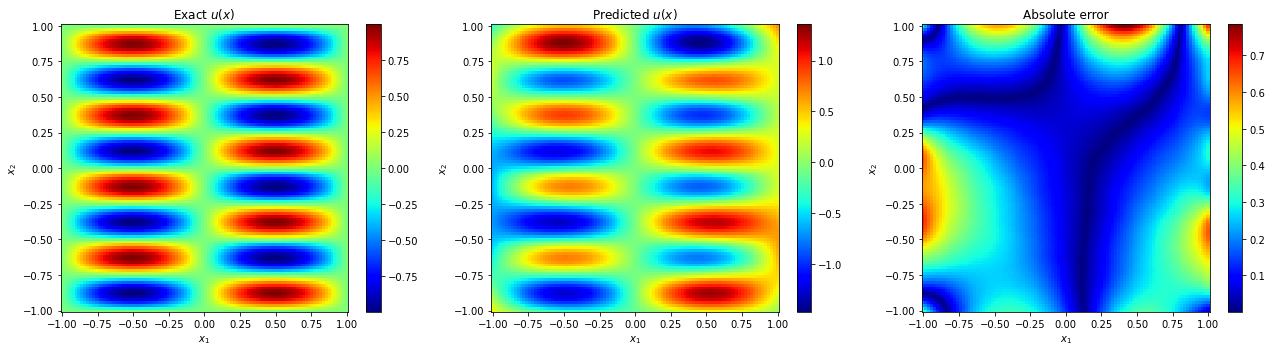

In [5]:

# Test data
nn = 100
x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
x1, x2 = np.meshgrid(x1, x2)
X_star = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))

# Exact solution
u_star = u(X_star, a_1, a_2)
f_star = f(X_star, a_1, a_2, lam)

# Predictions
u_pred = model.predict_u(X_star)
f_pred = model.predict_r(X_star)

# Relative error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_u: {:.2e}'.format(error_f))

### Plot ###

# Exact solution & Predicted solution
# Exact soluton
U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

# Predicted solution
U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(x1, x2, U_star, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Exact $u(x)$')

plt.subplot(1, 3, 2)
plt.pcolor(x1, x2, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Predicted $u(x)$')

plt.subplot(1, 3, 3)
plt.pcolor(x1, x2, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()


Relative L2 error_u: 4.83e-02
Relative L2 error_u: 1.30e-02


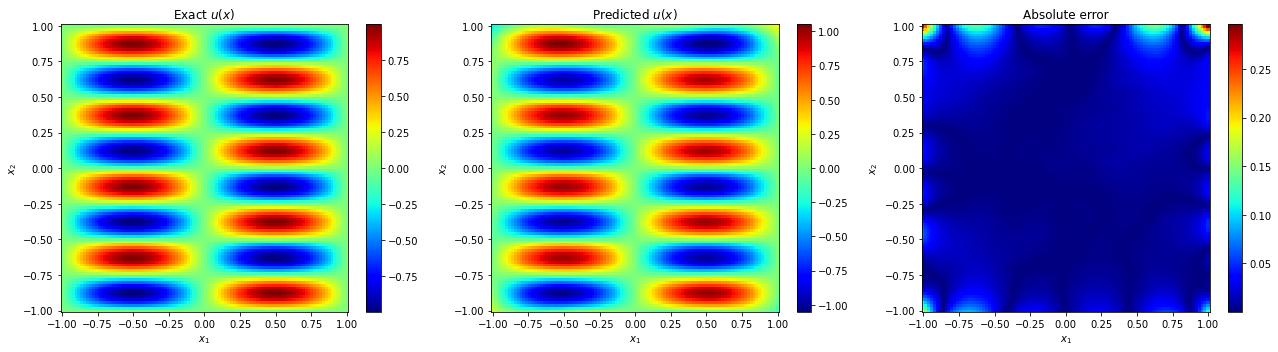

In [6]:

# Test data
nn = 100
x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
x1, x2 = np.meshgrid(x1, x2)
X_star = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))

# Exact solution
u_star = u(X_star, a_1, a_2)
f_star = f(X_star, a_1, a_2, lam)

# Predictions
u_pred = model.predict_u(X_star)
f_pred = model.predict_r(X_star)

# Relative error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_u: {:.2e}'.format(error_f))

### Plot ###

# Exact solution & Predicted solution
# Exact soluton
U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

# Predicted solution
U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(x1, x2, U_star, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Exact $u(x)$')

plt.subplot(1, 3, 2)
plt.pcolor(x1, x2, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Predicted $u(x)$')

plt.subplot(1, 3, 3)
plt.pcolor(x1, x2, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()


Relative L2 error_u: 2.98e-01
Relative L2 error_u: 1.22e-02


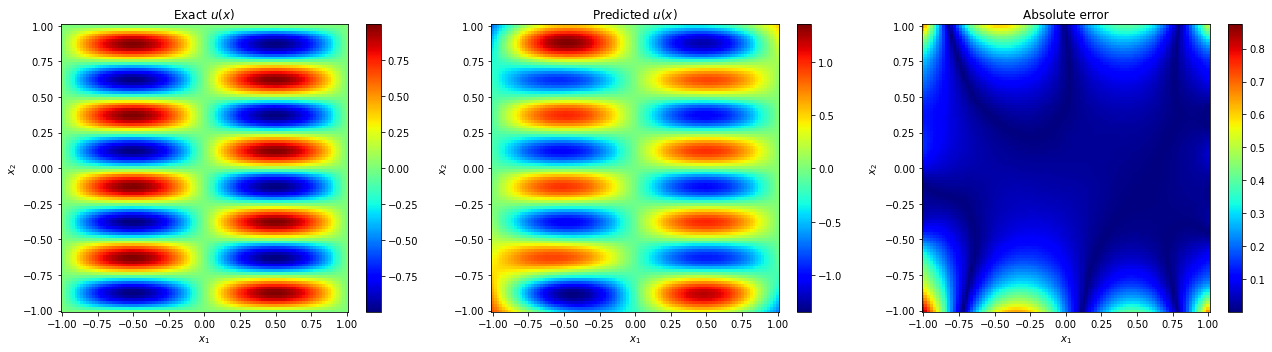

In [5]:

# Test data
nn = 100
x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
x1, x2 = np.meshgrid(x1, x2)
X_star = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))

# Exact solution
u_star = u(X_star, a_1, a_2)
f_star = f(X_star, a_1, a_2, lam)

# Predictions
u_pred = model.predict_u(X_star)
f_pred = model.predict_r(X_star)

# Relative error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_u: {:.2e}'.format(error_f))

### Plot ###

# Exact solution & Predicted solution
# Exact soluton
U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

# Predicted solution
U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(x1, x2, U_star, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Exact $u(x)$')

plt.subplot(1, 3, 2)
plt.pcolor(x1, x2, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Predicted $u(x)$')

plt.subplot(1, 3, 3)
plt.pcolor(x1, x2, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()


Relative L2 error_u: 1.79e-02
Relative L2 error_u: 9.96e-03


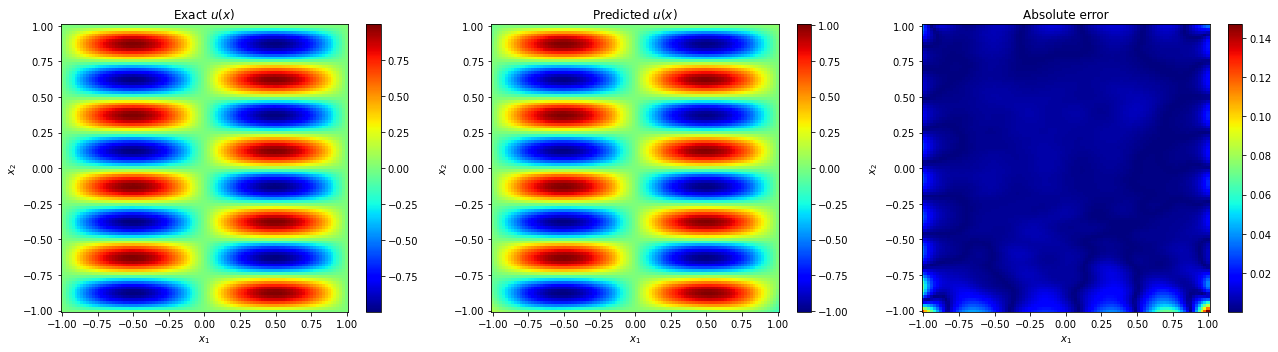

In [8]:

# Test data
nn = 100
x1 = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x2 = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
x1, x2 = np.meshgrid(x1, x2)
X_star = np.hstack((x1.flatten()[:, None], x2.flatten()[:, None]))

# Exact solution
u_star = u(X_star, a_1, a_2)
f_star = f(X_star, a_1, a_2, lam)

# Predictions
u_pred = model.predict_u(X_star)
f_pred = model.predict_r(X_star)

# Relative error
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_f = np.linalg.norm(f_star - f_pred, 2) / np.linalg.norm(f_star, 2)

print('Relative L2 error_u: {:.2e}'.format(error_u))
print('Relative L2 error_u: {:.2e}'.format(error_f))

### Plot ###

# Exact solution & Predicted solution
# Exact soluton
U_star = griddata(X_star, u_star.flatten(), (x1, x2), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (x1, x2), method='cubic')

# Predicted solution
U_pred = griddata(X_star, u_pred.flatten(), (x1, x2), method='cubic')
F_pred = griddata(X_star, f_pred.flatten(), (x1, x2), method='cubic')

fig_1 = plt.figure(1, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(x1, x2, U_star, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Exact $u(x)$')

plt.subplot(1, 3, 2)
plt.pcolor(x1, x2, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Predicted $u(x)$')

plt.subplot(1, 3, 3)
plt.pcolor(x1, x2, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()


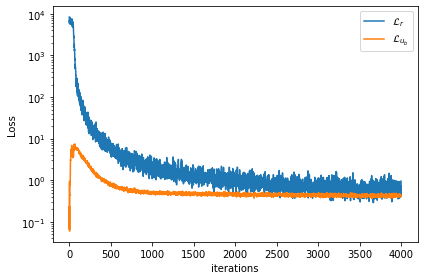

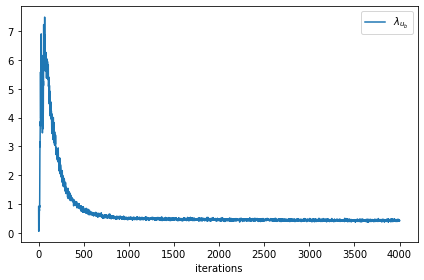

In [6]:

# Residual loss & Boundary loss
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log

fig_2 = plt.figure(2)
ax = fig_2.add_subplot(1, 1, 1)
ax.plot(loss_res, label='$\mathcal{L}_{r}$')
ax.plot(loss_bcs, label='$\mathcal{L}_{u_b}$')
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Adaptive Constant
adaptive_constant = model.adpative_constant_log

fig_3 = plt.figure(3)
ax = fig_3.add_subplot(1, 1, 1)
ax.plot(adaptive_constant, label='$\lambda_{u_b}$')
ax.set_xlabel('iterations')
plt.legend()
plt.tight_layout()
plt.show()

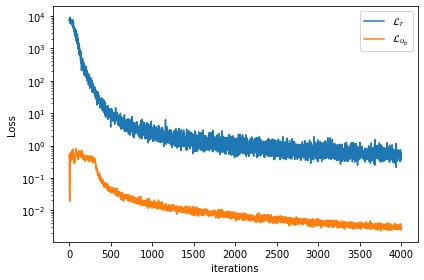

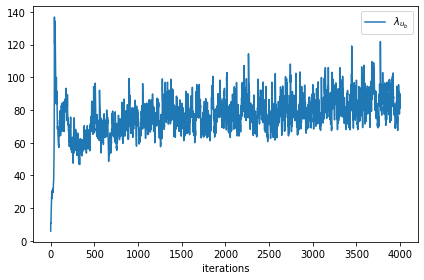

In [9]:

# Residual loss & Boundary loss
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log

fig_2 = plt.figure(2)
ax = fig_2.add_subplot(1, 1, 1)
ax.plot(loss_res, label='$\mathcal{L}_{r}$')
ax.plot(loss_bcs, label='$\mathcal{L}_{u_b}$')
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Adaptive Constant
adaptive_constant = model.adpative_constant_log

fig_3 = plt.figure(3)
ax = fig_3.add_subplot(1, 1, 1)
ax.plot(adaptive_constant, label='$\lambda_{u_b}$')
ax.set_xlabel('iterations')
plt.legend()
plt.tight_layout()
plt.show()

/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/afrah2/anaconda3/envs/twoPhase/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

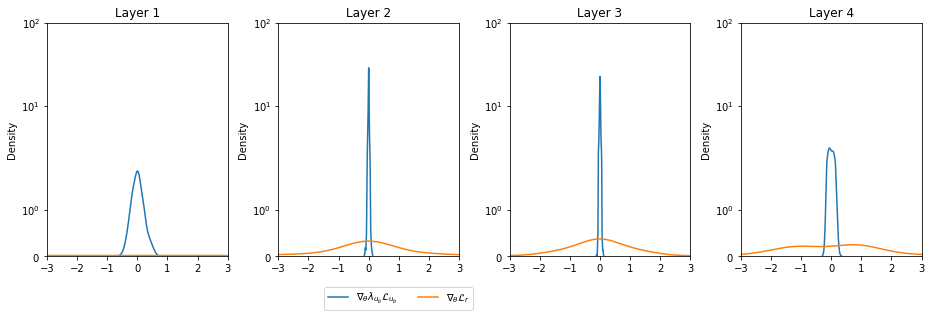

In [7]:


# Gradients at the end of training
data_gradients_res = model.dict_gradients_res_layers
data_gradients_bcs = model.dict_gradients_bcs_layers

gradients_res_list = []
gradients_bcs_list = []

num_hidden_layers = len(layers) - 1
for j in range(num_hidden_layers):
    gradient_res = data_gradients_res['layer_' + str(j + 1)][-1]
    gradient_bcs = data_gradients_bcs['layer_' + str(j + 1)][-1]

    gradients_res_list.append(gradient_res)
    gradients_bcs_list.append(gradient_bcs)

cnt = 1
fig_4 = plt.figure(4, figsize=(13, 4))
for j in range(num_hidden_layers):
    ax = plt.subplot(1, 4, cnt)
    ax.set_title('Layer {}'.format(j + 1))
    ax.set_yscale('symlog')
    gradients_res = data_gradients_res['layer_' + str(j + 1)][-1]
    gradients_bcs = data_gradients_bcs['layer_' + str(j + 1)][-1]
    sns.distplot(gradients_bcs, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \lambda_{u_b} \mathcal{L}_{u_b}$')
    sns.distplot(gradients_res, hist=False,
                    kde_kws={"shade": False},
                    norm_hist=True, label=r'$\nabla_\theta \mathcal{L}_r$')
    
    # ax.get_legend().remove()
    ax.set_xlim([-3.0, 3.0])
    ax.set_ylim([0,100])
    cnt += 1
handles, labels = ax.get_legend_handles_labels()
fig_4.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.01),
            borderaxespad=0, bbox_transform=fig_4.transFigure, ncol=2)
plt.tight_layout()
plt.show()


In [11]:

# Eigenvalues if applicable
if stiff_ratio:
    eigenvalues_list = model.eigenvalue_log
    eigenvalues_bcs_list = model.eigenvalue_bcs_log
    eigenvalues_res_list = model.eigenvalue_res_log
    eigenvalues_res = eigenvalues_res_list[-1]
    eigenvalues_bcs = eigenvalues_bcs_list[-1]

    fig_5 = plt.figure(5)
    ax = fig_5.add_subplot(1, 1, 1)
    ax.plot(eigenvalues_res, label='$\mathcal{L}_r$')
    ax.plot(eigenvalues_bcs, label='$\mathcal{L}_{u_b}$')
    ax.set_xlabel('index')
    ax.set_ylabel('eigenvalue')
    ax.set_yscale('symlog')
    plt.legend()
    plt.tight_layout()
    plt.show()

